In [1]:
import torch 
import torchaudio

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)


2.1.2
2.1.2
cuda


In [2]:
import IPython
import matplotlib.pyplot as plt

### Character-based encoding

In [3]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text]

text = "Hello world! Text to speech!"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


In [4]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()
text = "Hello world! Text to speech!"
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])
tensor([28], dtype=torch.int32)


In [5]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


### Phenome-based encoding

In [6]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
text = "Hello world! Text to speech!"
with torch.inference_mode():
    processed, lengths = processor(text)
print(processed)
print(lengths)

tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38,  2, 11, 81, 40, 64, 79, 81, 11, 81,
         20, 11, 79, 77, 59, 37,  2]])
tensor([25], dtype=torch.int32)


/home/aslathe/miniconda3/envs/trans/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', '!', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH', '!']


### Spectrogram Generation

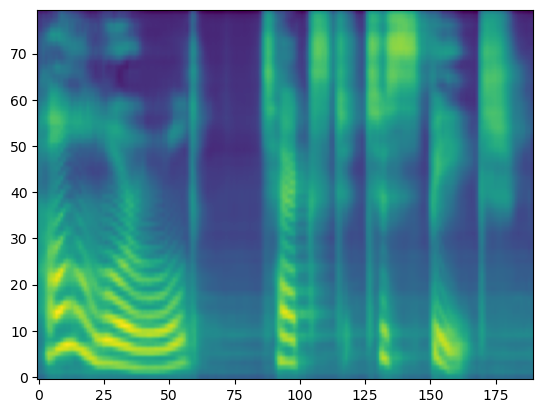

In [8]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)

_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

torch.Size([80, 190])
torch.Size([80, 184])
torch.Size([80, 185])


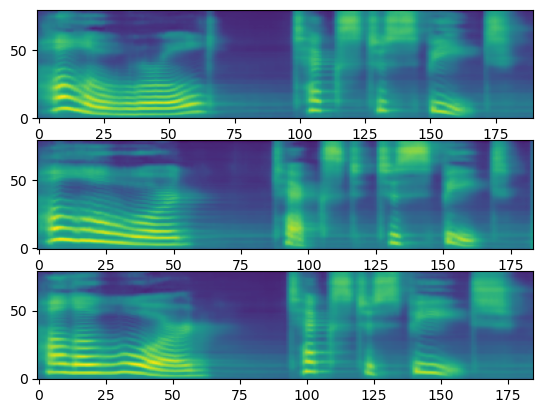

In [9]:
def plot():
    fig, ax = plt.subplots(3, 1)
    for i in range(3):
        with torch.inference_mode():
            spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        print(spec[0].shape)
        ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")


plot()

### Waveform Generation

#### WaveRNN

In [17]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hello world! "

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

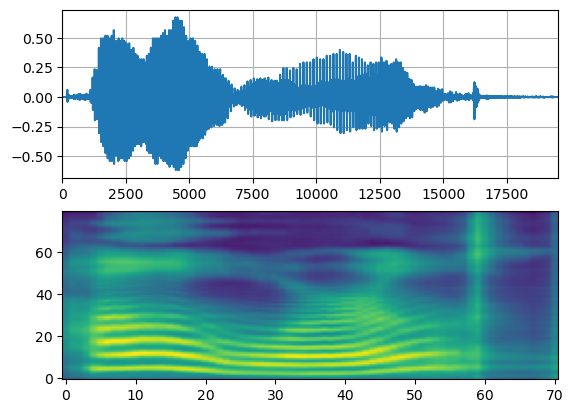

In [18]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()
    
    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)
plot(waveforms, spec, vocoder.sample_rate)

### Griffin-Lim

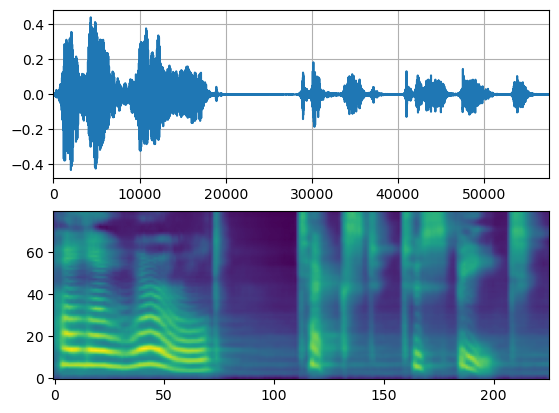

In [20]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

plot(waveforms, spec, vocoder.sample_rate)

In [23]:
import scipy.io.wavfile 

sample_rate = vocoder.sample_rate
output_file = "test.wav"
scipy.io.wavfile.write("test.wav", sample_rate, waveforms[0:1])


AttributeError: 'torch.dtype' object has no attribute 'kind'